### They inner atoms, and the outer atoms are equally spaced
### Find out the N-dependance

In [77]:
from tqdm import tqdm
from qutip import *
import numpy as np
import pickle

from scipy.optimize import minimize

import os

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from functools import partial

In [78]:
save_path = r'C:\Users\leopo\OneDrive - UT Cloud\Uni\Semester_8\BA_mit_Git\BA_Plots\Qutip'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

In [112]:
# Define constants
fixed_lam = 1
fixed_gamma = 1
fixed_dist_ext = 0.235 * fixed_lam
fixed_dist_in = fixed_dist_ext
# Define the geometry functions
def dipole_vector(phi=0):
    """Returns the dipole vector given its orientation by angle phi."""
    dipole = np.array([np.cos(phi), np.sin(phi), 0])
    return dipole

def z_rotation(angle):
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle), np.cos(angle), 0],
        [0, 0, 1]])

def chain_positions(distance, N):
    Pos = np.zeros((N, 3))
    for i in range(N):
        Pos[i, 0] = i * distance
    return Pos

def corner_positions(N, distance_in=fixed_dist_in, distance_ext=fixed_dist_ext):
    Pos = np.zeros((N, 3))
    Chain = chain_positions(distance_ext, N//2)
    Pos[:N//2] = np.dot(Chain + [distance_in, 0, 0], z_rotation(np.pi).T)
    Pos = Pos[Pos[:, 0].argsort()]
    Pos[N//2:N-1] = np.dot(Chain + [distance_in, 0, 0], z_rotation(np.pi / 3).T)
#    Pos[-1] =  np.dot([distance_in, 0, 0], z_rotation(-np.pi / 3).T)
    return Pos
'''
positions = corner_positions(N)
# Plot atoms with their dipole moments
plt.figure(figsize=(12, 2))
plt.scatter(positions[:, 0], positions[:, 1], color='blue', s=50, label='Atoms')
plt.title('Atom Positions and Dipole Moments')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.legend()
plt.axis('equal')'''

"\npositions = corner_positions(N)\n# Plot atoms with their dipole moments\nplt.figure(figsize=(12, 2))\nplt.scatter(positions[:, 0], positions[:, 1], color='blue', s=50, label='Atoms')\nplt.title('Atom Positions and Dipole Moments')\nplt.xlabel('X Position')\nplt.ylabel('Y Position')\nplt.grid(True)\nplt.legend()\nplt.axis('equal')"

In [113]:
def Green_tensor(r_a, r_b, k_a):
    r_ab = r_b - r_a
    abs_r_ab = np.linalg.norm(r_ab)
    kappa = k_a * abs_r_ab
    return (np.exp(1j * kappa) / (4 * np.pi * kappa ** 2 * abs_r_ab)
            * ((kappa ** 2 + 1j * kappa - 1) * np.eye(3)
               + (- kappa ** 2 - 3 * 1j * kappa + 3)
               * np.outer(r_ab, r_ab) / (abs_r_ab ** 2)))

def Gamma_matrix(distance_in, distance_ext, dipoles, lam, gamma, N):
    positions = corner_positions(N, distance_in, distance_ext)
    G_matrix = np.zeros((N, N), dtype=complex)
    for a in range(N):
        for b in range(N):
            G_matrix[a, b] = gamma
            r_a, r_b = positions[a], positions[b]
            if np.linalg.norm(r_b - r_a) > 1e-5:
                d_a, d_b = dipoles[a], dipoles[b]
                k_a = 2 * np.pi / lam
                G_matrix[a, b] = np.imag((6 * np.pi * gamma / k_a * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b, k_a), d_b.T))))
    return G_matrix

def V_matrix(distance_in, distance_ext, dipoles, lam, gamma, N):
    positions = corner_positions(N, distance_in, distance_ext)
    V_matrix = np.zeros((N, N), dtype=complex)
    for a in range(N):
        for b in range(N):
            r_a, r_b = positions[a], positions[b]
            V_matrix[a, b] = 0
            if np.linalg.norm(r_b - r_a) > 1e-5:
                d_a, d_b = dipoles[a], dipoles[b]
                k_a = 2 * np.pi / lam
                V_matrix[a, b] = np.real((3 * np.pi * gamma / k_a * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b, k_a), d_b.T))))
    return V_matrix

def H_eff(distance_in=fixed_dist_in, distance_ext=fixed_dist_ext, dipoles=None, lam=fixed_lam, gamma=fixed_gamma, N=6):
    if dipoles is None:
        dipoles = [dipole_vector() for _ in range(N)]
    G = Gamma_matrix(distance_in, distance_ext, dipoles, lam, gamma, N)
    V = V_matrix(distance_in, distance_ext, dipoles, lam, gamma, N)
    return Qobj(V) - 1j / 2 * Qobj(G)

# Initialize wave-packet
k_s = np.pi / fixed_dist_ext
sigma = 0.1 * k_s

def create_wave_packet(N):
    center_index = N // 4
    x_j = (np.arange(N // 2) - center_index) * fixed_dist_ext
    coefficients = np.sqrt(sigma / np.sqrt(2 * np.pi)) * np.exp(-1j * k_s * x_j) * np.exp(-sigma**2 * x_j**2)
    wave_packet = sum(coeff * basis(N, j) for j, coeff in enumerate(coefficients))
    return wave_packet.unit()

# Functions for optimization
def survival_probabilities(dipoles, distance_in, times, distance_ext=fixed_dist_ext, lam=fixed_lam, gamma=fixed_gamma, Psi_0=None, N=6):
    H = H_eff(distance_in, distance_ext, dipoles, lam, gamma, N)
    coeffs_sq_mods = np.zeros((len(times), N))
    P_surs = np.zeros((len(times)))
    for t_idx, t in enumerate(times):
        U = (-1j * H * t).expm()
        Psi_t = (U * Psi_0).full().flatten()
        Probs = np.abs(Psi_t)**2
        coeffs_sq_mods[t_idx, :] = Probs
        P_surs[t_idx] = Probs.sum()
    return coeffs_sq_mods, P_surs

def dipole_angles_and_distance(params, N):
    angles = params[:N]
    distance_in = params[N]
    dipoles = [dipole_vector(angle) for angle in angles]
    return dipoles, distance_in

def optimization_target(params, times, target_indices, Psi_0, N):
    dipoles, distance_in = dipole_angles_and_distance(params, N)
    res, _ = survival_probabilities(dipoles, distance_in, times, Psi_0=Psi_0, N=N)
    # Sum probabilities of the states in the target indices
    target_prob = np.sum(res[-1, target_indices])
    # We want to maximize the target probability
    return -target_prob

In [114]:
m = 5
N = 2*m+1

# Set up initial conditions
t_max    = 45
t_size    = 200
times  = np.linspace(0, t_max, t_size) * fixed_gamma


In [115]:
# Initial guess for the distance and angles
initial_distance = 0.234 * fixed_lam
initial_angles = [8.56243885e-01, 5.45393047e-01, 3.85418697e-01, 3.18513591e-01, 3.09201236e-01, 3.18809638e-01, 3.02352737e-01, 2.45478456e-01, 1.90687899e-01, 1.81840059e-01, 2.92083938e-01]
initial_params = np.hstack((initial_angles, initial_distance))

# Bounds for the optimization
angle_bounds = [(0, 2 * np.pi) for _ in range(N)]
distance_in_bounds = [(0.1, 1)]
bounds = angle_bounds + distance_in_bounds

# Indices of the atoms in the target regions
target_indices = list(range(N // 2 + 1, N))  # Example, assuming the target regions are the second third

# Create initial wave packet Psi_0
Psi_0 = create_wave_packet(N)

# Optimization with bounds
result = minimize(optimization_target, initial_params, args=(times, target_indices, Psi_0, N), bounds=bounds, method='SLSQP')

# Debugging print statements
print("Optimization result:", result)

# Print results
print("Optimized Angles:", result.x[:N])
print("Optimized Inner Distance:", result.x[N])

Optimization result:  message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.592424482774968
       x: [ 8.983e-01  6.884e-01  6.074e-01  5.314e-01  4.954e-01
            6.251e-01  6.151e-01  5.242e-01  3.983e-01  9.431e-02
            5.530e-01  1.860e-01]
     nit: 32
     jac: [-1.557e-04 -2.095e-04 -4.442e-05  3.141e-04  6.327e-04
            1.449e-04 -3.051e-04 -2.585e-04  4.324e-04  9.129e-05
            7.331e-04 -1.825e-03]
    nfev: 447
    njev: 32
Optimized Angles: [0.89834765 0.6883969  0.60736115 0.53141933 0.49536319 0.62511958
 0.61512248 0.52418303 0.39828206 0.0943091  0.55302182]
Optimized Inner Distance: 0.18597346439012752


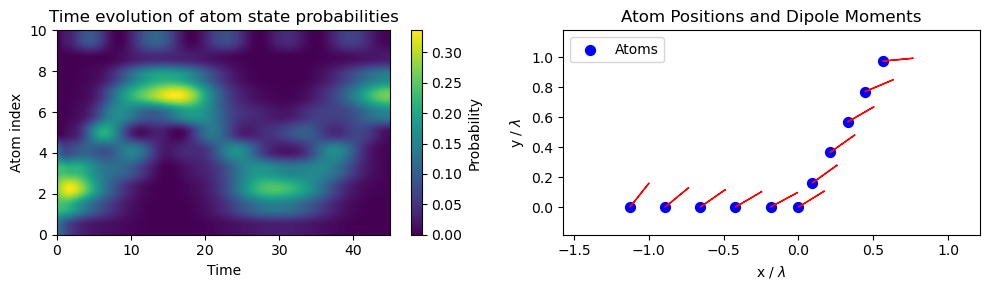

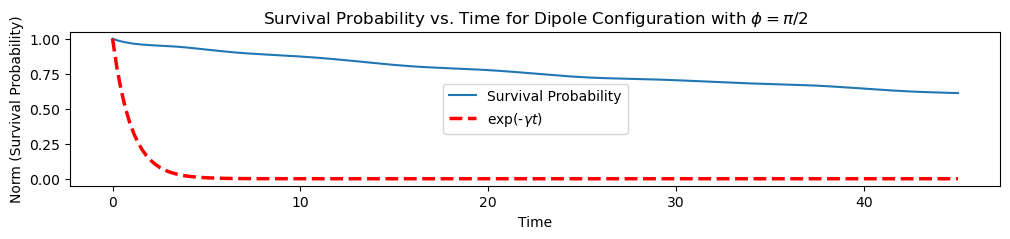

In [116]:
dipoles, optimized_distance_in = dipole_angles_and_distance(result.x, N)

# Generate positions based on optimized distance
positions = corner_positions(N, optimized_distance_in)

# Compute survival probabilities with optimized dipoles and distance
y1, y2 = survival_probabilities(dipoles, optimized_distance_in, times, Psi_0=Psi_0, N=N)

# Plot the evolution of atom state probabilities
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
im = ax1.imshow(y1.T, aspect='auto', origin='lower', cmap='viridis', extent=[0, t_max, 0, N-1])
ax1.set_xlabel('Time')
ax1.set_ylabel('Atom index')
ax1.set_title('Time evolution of atom state probabilities')
fig.colorbar(im, ax=ax1, label='Probability')

# Plot atoms with their dipole moments
ax2.scatter(positions[:, 0], positions[:, 1], color='blue', s=50, label='Atoms')
for i in range(N):
    ax2.arrow(positions[i, 0], positions[i, 1], dipoles[i][0] * 0.2, dipoles[i][1] * 0.2, head_width=0.5 * 0.01, head_length=0.5 * 0.01, fc='red', ec='red')
ax2.set_title('Atom Positions and Dipole Moments')
ax2.set_xlabel('x / $\lambda$')
ax2.set_ylabel('y / $\lambda$')
ax2.legend()
ax2.axis('equal')

plt.tight_layout()
plt.show()

# Plot the norms against time
plt.figure(figsize=(12, 2))
plt.plot(times, y2, label='Survival Probability')
plt.plot(times, np.exp(-times), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
plt.xlabel('Time') 
plt.ylabel('Norm (Survival Probability)')
plt.title('Survival Probability vs. Time for Dipole Configuration with $\phi = \pi/2$')
plt.legend()
plt.show()